In [1]:
import xarray as xr
import numpy as np
import torch
import pytorch_lightning as pl
import torch.nn as nn
#import xrft
import matplotlib.pyplot as plt
#import pandas as pd
from tqdm import tqdm
import os
import glob
from pathlib import Path
from typing import Union, List
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
import torch.nn.functional as F
import cartopy.crs as ccrs
import pickle
import time

In [2]:
from src.utils import load_ssf_acoustic_variables, load_sound_speed_fields
from src.data import TrainingItem, AutoEncoderDatamodule, BaseDatamodule
from src.acoustic_predictor import ConvBlock, AcousticPredictor
from src.autoencoder import AutoEncoder

In [3]:

sound_speed_path = "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ecs_path = "/DATASET/envs/o23gauvr/tmp/eNATL60_BLB002_ECS_at_0_regrid_0_1000m.nc"

In [4]:
ae_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_15_relu_lr_0.001/2024-04-15_21-23"
model_ae_path = glob.glob(f"{ae_path}/**/*.ckpt", recursive=True)[0]
pickle_ae_path = glob.glob(f"{ae_path}/**/*.pickle", recursive=True)[0]
arch_shape = '_'.join(ae_path.split('/')[-1].split('_')[:2])

model_ap_path= "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/"
model_ap_path = glob.glob(f"{model_ap_path}/**/*.ckpt", recursive=True)[0]
acoustic_predictor = AcousticPredictor.load_from_checkpoint(checkpoint_path = model_ap_path, input_depth= 107)


print('ae model: ', model_ae_path)

print('ap model: ', model_ap_path)

ae model:  /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_15_relu_lr_0.001/2024-04-15_21-23/checkpoints/val_loss=0.04-epoch=955.ckpt
ap model:  /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/accoustic_predictor/lucas_model/2024-04-22_19-01/checkpoints/val_loss=0.00-epoch=950.ckpt


In [5]:
with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/profiles_of_interest_idx.pkl", "rb") as file:
    profile_idx_dict = pickle.load(file)

profile_idx_dict

{'min_std': tensor([[ 18, 100,  83],
         [ 18, 100,  82],
         [ 18, 100,  84],
         [ 18, 101,  83],
         [ 35, 100,  85],
         [ 18,  99,  83],
         [ 35,  99,  85],
         [ 35, 100,  86],
         [ 18, 101,  84],
         [ 35,  99,  84],
         [ 18,  99,  82],
         [ 35,  99,  86],
         [ 18, 101,  82],
         [ 35, 100,  84],
         [ 18,  99,  84],
         [ 18, 100,  81],
         [ 35, 100,  87],
         [ 35,  99,  83],
         [ 18, 100,  85],
         [ 18,  99,  81],
         [ 18, 101,  85],
         [ 18, 101,  81],
         [ 35, 100,  83],
         [ 35,  99,  87],
         [ 18,  98,  83],
         [ 18, 102,  83],
         [ 35, 101,  85],
         [ 35,  98,  84],
         [ 18, 102,  84],
         [ 35, 101,  86]]),
 'max_std': tensor([[ 22, 107,   0],
         [ 22, 107,   1],
         [ 22, 108,   1],
         [ 22, 106,   0],
         [ 22, 110,   4],
         [ 22, 108,   2],
         [ 22, 109,   3],
         [ 22,

In [6]:
y_min_axs = -20
y_max_axs = 1020
x_min_axs = 1450
x_max_axs = 1550

In [7]:
plt.style.use('ggplot')

In [8]:
gpu = None

if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [9]:
load_data = True

# Functions

## load datamodule

In [10]:

def init_ae(model_ae_path:str,  
            sound_speed_path:str, 
            ecs_path:Union[str, None] = None, 
            gpu:Union[int, None]= None, 
            verbose:float = True):
    
    
    if torch.cuda.is_available() and gpu is not None:
    ##This may not be necessary outside the notebook
        dev = f"cuda:{gpu}"
    else:
        dev = "cpu"

    device = torch.device(dev)

    if verbose:
        print("Selected device:", device)


    if model_ae_path[-5:] == ".ckpt":
        pass

    elif os.path.isdir(model_ae_path):
        model_ae_path = glob.glob(os.path.join(model_ae_path, "**/*.ckpt"), recursive=True)[0]

    else:
        raise ValueError("model_ae_path should leads towards a chekpoint file (.ckpt) or toward a directory containing one checkpoint file. Research in sub_directories is allowed but only the chekpoint file found first is retrieved")

    ap_indicator, arch_shape =  model_ae_path.split("/")[-4:-2]

    
    if verbose:
        print("Selected AutoEncoder model:", model_ae_path)

    if ap_indicator == "AE_with_AP" : 

        if ecs_path is None:
            raise ValueError("For models using acoustic predictor, ecs_path should be defined")
        
        
        input_da = load_ssf_acoustic_variables(sound_speed_path, ecs_path) 
        
        #* By default the first chekpoint is selected
        
    else:
        model_ap_path = None
        input_da = load_sound_speed_fields(sound_speed_path)  
        
    if verbose:
        print("Selected Accoustic Predictor model:", str(model_ap_path)) 
        print("Loading celerity data")
    
    return input_da, ap_indicator, arch_shape, device

In [11]:
def test_dataloader_normalization(dataloader):
    
    for batch_number, batch in enumerate(dataloader):
        
        errors = []
        if batch.input.min() < -1:
            errors.append("Minimum value of input is less than -1.")
        if batch.input.max() > 1:
            errors.append("Maximum value of input is greater than 1.")
        if batch.tgt[::, :].min() < -1:
            errors.append("Minimum value of target ECS is less than -1.")
        if batch.tgt[::, :].max() > 1:
            errors.append("Maximum value of target ECS is greater than 1.")
        if abs(batch.input.max() - batch.input.min()) > 2:
            errors.append("Absolute difference between input max and min is greater than 2.")
        if abs(batch.tgt[:, :, :].max() - batch.tgt[:, :, :].min()) > 2:
            errors.append("Absolute difference between target ECS max and min is greater than 2.")
        
        if errors:
            error_message = "Validation failed for batch {}: {}".format(batch_number, "\n ".join(errors))
            raise ValueError(error_message)

In [12]:
def load_datamodule(input_da: tuple, 
                    x_min: Union[float, None] = None, 
                    x_max: Union[float, None] = None, 
                    phases: Union[str, List[str]] = ["train", "test"], 
                    domains: dict = dict(
                        train = dict(time = slice(0, 254, None)), 
                        val = dict(time = slice(254, 331, None)), 
                        test = dict(time = slice(331, 365, None))
                        ), 
                    verbose:float = True
                    ):
    
    
    if isinstance(phases, str):
        phases = list(phases)
    
    elif isinstance(phases, list):
        pass
    
    else: 
        raise ValueError("Argument phases should be a string or a list of strings")
    
    dm_dict = dict()
    
    dl_kw = dict(batch_size = None, 
                 num_workers = 1)
    
    fit_setup = False
    
    dm = BaseDatamodule(input_da, dl_kw = dl_kw, x_min=x_min, x_max =x_max)
    
    
    for phase in tqdm(phases, unit = "phase", desc = "Genereting Dataloaders on selected splits"):
        
        if verbose:
            print("phase:", phase)


        
        # print(input_da[0].celerity.data.min(), input_da[0].celerity.data.max())
        # #coords = input_da.isel(domains[phase]).coords


        if phase == 'train':

            if not fit_setup:
                if verbose:
                    print("\t Train setup")
                dm.setup(stage = 'fit')
                fit_setup = True
            
            if verbose:
                print("\tGenerating dataloader")
                
            dm.dl_kw['batch_size'] = len(dm.train_ds.volume.coords['time'])
            dataloader = dm.train_dataloader()
        
        
        elif phase == "val":

            
            if not fit_setup:
                if verbose:
                    print("\t Validation setup")
                dm.setup(stage = 'fit')
                fit_setup = True
            
            if verbose:
                print("\tGenerating dataloader")
            dm.dl_kw['batch_size'] = len(dm.val_ds.volume.coords['time'])
            dataloader = dm.val_dataloader()
        
        
        elif phase == 'test':  
            if verbose:
                print("\t Test setup")
            dm.setup(stage = 'test')
            
            if verbose:
                print("\tGenerating dataloader")
            
            dm.dl_kw['batch_size'] = len(dm.test_ds.volume.coords['time'])
            dataloader = dm.test_dataloader()

        else: 
            raise ValueError("phase in phases should be train, val or test")
        
        if len(dataloader) != 1:
                raise ValueError("Dataloader should only contain 1 batch. This should never be seen for debugging purpose only")

        if verbose:
            print("Testing dataloader normalization")
        test_dataloader_normalization(dataloader)
            
        


            

        batch = next(iter(dataloader))

        dm_dict[phase] = batch
        

        
    return dm_dict



## ECS

In [13]:
def reduce_profile(z_w, sos_w):
    """
    Reduce a profile by finding min-max singular points (linear reduction)

    Parameters
    ----------
    z_w : Float array
        depth values (in m > 0).
    sos_w : Float array
        sound velocities along z_w (in m/s).

    Comment
    -------
    Assumption is made by the profile is regular (starts at surface and stop at
    bottom). None or nan value need to be dealt with before the reduction

    Returns
    -------
    z_w_red : Float array
        Singular point depth values.
    sos_w_red : Float array
        Singular point sound speed values.

    """
    # compute the sign of consecutive points differences, then, search where
    # change occurs by differencing again and finding where results equal 2.
    ind = np.where(abs(np.diff(np.sign(np.diff(sos_w)))) == 2)
    # compensation for loosing one in index dimension due to differencation
    ind += np.ones((len(ind)))

    sos_w_red = sos_w[[int(i) for i in ind[0]]]
    z_w_red = z_w[[int(i) for i in ind[0]]]

    # insert surface point and bottom point
    sos_w_red = np.insert(sos_w_red, 0, sos_w[0])
    z_w_red = np.insert(z_w_red, 0, 0)
    sos_w_red = np.insert(sos_w_red, len(sos_w_red), sos_w[-1])
    z_w_red = np.insert(z_w_red, len(z_w_red), z_w[-1])

    return z_w_red, sos_w_red

In [14]:
def compute_surface_duct_width(z_w_red, sos_w_red):
    """
    Compute surface duct width of a reduced profile considering only the sign
    of the first gradient

    Parameters
    ----------
    z_w_red : Float array
        depths of the singular points in the reduced profile (m > 0).
    sos_w_red : Float array
        speed of sound at the singular points (in m/s).

    Returns
    -------
    surf_duct_width : Float
        Surface duct width (in m).

    Comments
    --------
    Must be used on a prior reduced profile
    z_w_red, sos_w_red = reduce_profile(z_w, sos_w)
    z_surf_duct = compute_ecs(z_w_red, sos_w_red)

    """
    surf_duct_width = max(0, np.sign(sos_w_red[1] - sos_w_red[0]) * z_w_red[1])
    return surf_duct_width

In [15]:
def get_ecs(z_w, sos_w):
    """_summary_

    Args:
    z_w : Float array
        depth values (in m > 0).
    sos_w : Float array
        sound velocities along z_w (in m/s).

    """

    z_w_red, sos_w_red = reduce_profile(z_w, sos_w)
    return compute_surface_duct_width(z_w_red, sos_w_red)
    

## Plot

In [16]:
def plot_4_profiles(output_test_decoded_pca_dict, ae_model_list, output_ae_test_dict, profiles, coords_test = coords_test, y_lim = (y_min_axs,y_max_axs), savefig = False):

    style = ['-', '--', '-.', ':']
    colors_ae = ['olive','mediumseagreen','deepskyblue','orchid']
    colors_pca = ['brown', 'lightcoral','gold','chocolate']
    title_dict = {'min_std': "Celerity profiles presenting the lowest std",
              'max_std': "Celerity profiles presenting the highest std",
              'min_std_150': "Celerity profiles presenting the lowest std along the first 150m",
              'max_std_150': "Celerity profiles presenting the highest std along the first 150m",
              'min_ecs': "Celerity profiles presenting the lowest ecs",
              'max_ecs': "Celerity profiles presenting the highest ecs",
              'max_std_lat': "Celerity profiles along the latitude presenting the highest std",
              'max_std_lon': "Celerity profiles along the longitude presenting the highest std",
              'random_1000': "Random celerity profiles"
              }
    
    fig, axs = plt.subplots(2, 2, figsize = (15, 12))

    for i, ax in enumerate(axs.flatten()):
        idx_tuple = profile_idx_dict[profiles][i]
        ax.plot(x_test[idx_tuple[0], :, idx_tuple[1], idx_tuple[2]]*(x_max - x_min)+ x_min, coords_da['z'].values, label = 'Ground truth', c ='b', linewidth = 4)
        
        for j,items in enumerate(output_test_decoded_pca_dict.items()):
            n_components,output_test_decoded_pca = items
            ax.plot(output_test_decoded_pca[idx_tuple[0], :, idx_tuple[1], idx_tuple[2]]*(x_max - x_min)+ x_min, coords_da['z'].values, label = f'PCA n° components: {n_components}', c=colors_pca[j%len(colors_pca)])

        for j, model in enumerate(ae_model_list):
            try:
                ax.plot(output_ae_test_dict[model][idx_tuple[0], :, idx_tuple[1], idx_tuple[2]]*(x_max - x_min)+ x_min, coords_da['z'].values, 
                        label = f"{model}", 
                        c=colors_ae[j%len(colors_ae)], 
                        )

                ecs_ae = get_ecs(coords_da['z'].values, output_ae_test_dict[model][idx_tuple[0], :, idx_tuple[1], idx_tuple[2]])
                ax.axhline(y= ecs_ae, c = colors_ae[j%len(colors_ae)] , linestyle = style[j%len(style)]) #label=f'ECS derieved from AE'
            
            except:
                print(f"Latitude {idx_tuple[1]} is not available for model: {model}")
                continue

        ecs_truth = y_test[idx_tuple[0], :, idx_tuple[1], idx_tuple[2]]*670.25141631
        ecs_pca = get_ecs(coords_da['z'].values, output_test_decoded_pca[idx_tuple[0], :, idx_tuple[1], idx_tuple[2]])
        ax.axhline(y= ecs_truth, c = 'b' , linestyle='--', lw = 4) #, label=f'ECS derieved from ground truth'
        ax.axhline(y= ecs_pca, c = 'r' , linestyle='--') #, label=f'ECS derieved from PCA'
        
        ax.set_ylim(y_lim[0], y_lim[1])  # Set y-axis limits
        #ax.set_xlim(x_min_axs, x_max_axs)  # Set x-axis limits
        ax.invert_yaxis()
        ax.set_xlabel('celerity (m/s)')
        ax.set_ylabel('depth (m)')
        ax.legend()
        ax.set_title(f"t:{coords_test['time'][idx_tuple[0]].astype('datetime64[D]')}, lat: {np.round(float(coords_test['lat'][idx_tuple[1]].values),2)}, lon: {np.round(float(coords_test['lon'][idx_tuple[2]].values),2)}",
                     fontsize = 12)
    title = title_dict[profiles]
    fig.suptitle(title, y = 0.93, fontsize = 15)

NameError: name 'coords_test' is not defined

In [ ]:
def RMSE_per_PCA_components(rmse_pca_per_components_dict,rmse_ae_dict,mode_ae_list):

    fig,axs = plt.subplots(1,2,figsize=(18,8))
    #plt.figure(figsize=(10, 8))
    style = ['-', '--', '-.', ':']
    colors = ['olive','mediumseagreen','deepskyblue','orchid']
    rmse_pca_ss = rmse_pca_per_components_dict['celerity']
    rmse_pca_ecs = rmse_pca_per_components_dict['ecs']


    # Plot the data
    axs[0].plot(list(rmse_pca_ss.keys()), list(rmse_pca_ss.values()), label='pca', c='r')
    axs[1].plot(list(rmse_pca_ecs.keys()), list(rmse_pca_ecs.values()), label='pca', c='r')


    for i, model in enumerate(mode_ae_list):
        axs[0].axhline(y=rmse_ae_dict['celerity'][model], linestyle=style[i%len(style)], label=f'AE {model}', c=colors[i%len(colors)])
        axs[1].axhline(y=rmse_ae_dict['ecs'][model], linestyle=style[i%len(style)], label=f'AE {model}', c=colors[i%len(colors)])

    # Add labels and title
    axs[0].set_xlabel('n components')
    axs[1].set_xlabel('n components')
    axs[0].set_ylabel('RMSE (normalized)')
    axs[1].set_ylabel('RMSE (m)')
    axs[0].set_title('Sound Speed', fontsize = 13)
    axs[1].set_title('ECS', fontsize = 13)
    axs[0].legend()
    axs[1].legend()

    fig.suptitle('RMSE per PCA components', y = 0.97, fontsize = 15)


# Load Data

In [ ]:
if not load_data:
    ss_ds, acc_ds = load_ssf_acoustic_variables(sound_speed_path, ecs_path)

In [ ]:
acc_ds = load_ssf_acoustic_variables(sound_speed_path, ecs_path)[1]

## Time split

In [ ]:
# with open(pickle_ae_path, 'rb') as file:
#     time_idx_split = pickle.load(file)
    
# time_idx =  np.concatenate(list(time_idx_split.values()))



In [ ]:
# if not load_data:
#     ss_ds = ss_ds.reindex(time=time_idx)
#     acc_ds = acc_ds.reindex(time=time_idx)


# acc_ds_test = acc_ds.sel(time=time_idx_split['test'])
# ss_ds_test = ss_ds.sel(time=time_idx_split['test'])
# coords_test = ss_ds_test.coords

This selection is rather long, should not be rerun every time

## Manage NaN

In [ ]:
# print(ss_ds.dropna(dim='lat').dims)
# print(ss_ds.dropna(dim='lon').dims)
# print(ss_ds.dropna(dim='time').dims)
# print(ss_ds.dropna(dim='z').dims)


In [ ]:
if not load_data:

    ss_ds = ss_ds.dropna(dim='lat')
    acc_ds = acc_ds.sel(lat = ss_ds.lat)


In [ ]:
if not load_data:
    input_da = (ss_ds, acc_ds)

    del ss_ds
    del acc_ds

In [ ]:
if not load_data:
    with open("/DATASET/envs/o23gauvr/tmp/input_da_no_nan.pkl", "wb") as file:
        pickle.dump(input_da, file)
        coords_da = input_da[0].coords
        
else: 
    # with open("/DATASET/envs/o23gauvr/tmp/input_da_no_nan.pkl", "rb") as file:
    #     coords_da = pickle.load(file)[0].coords

    coords_da = xr.open_dataarray(sound_speed_path).coords



# Load datamodule

In [ ]:


x_min = 1459.0439165829073
x_max = 1545.8698054910844
verbose = True
gpu = None

domains = dict(
    train = dict(time = slice(0, 254, None)), 
    val = dict(time = slice(254, 331, None)), 
    test = dict(time = slice(331, 365, None))
    )


In [ ]:
if not load_data:
    dm = load_datamodule(input_da, 
                        x_min, 
                        x_max
                        )
    
    with open("/DATASET/envs/o23gauvr/tmp/datamodule_test_train_no_nan.pkl", "wb") as file:
        pickle.dump(dm, file)
        
else:
    with open("/DATASET/envs/o23gauvr/tmp/datamodule_test_train_no_nan.pkl", "rb") as file:
        dm = pickle.load(file)

In [ ]:
x_train, y_train = dm['train']
input_train_shape = x_train.shape


x_test, y_test = dm['test']
input_test_shape = x_test.shape

print("\n normalization values")
print("x test min", x_test.min())
print("x test max", x_test.max())






 normalization values
x test min tensor(0.2012)
x test max tensor(0.9827)


In [ ]:
ae_dir_path = "/homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP"

output_ae_test_dict = {}
time_idx = []

#ae_path = list(ae_path_dict.values())[0]
model_ae_path = glob.glob(f"{ae_dir_path}/**/*.ckpt", recursive=True)


for ae_path in model_ae_path:
    arch_shape_struct = ae_path.split('/')[-4]
    
    xp = ae_path.split('/')[-5]
    if 'without' in xp:
        accoustic_training = False
    elif 'with' in  xp:
        accoustic_training = True
        
    #print(f"\nxp:{xp}  architecture:{arch_shape_struct}")
        
    try:
        model_ae = AutoEncoder.load_from_checkpoint(ae_path, 
                                                    x_min = x_min, 
                                                    x_max = x_max, 
                                                    arch_shape = arch_shape_struct, 
                                                    acoustic_predictor= acoustic_predictor, 
                                                    accoustic_training = accoustic_training).to(device)


    
    except:
        print(f"Error while loading model: {ae_path}")
        continue
        
    
    
    output_ae_test = model_ae(x_test.to(device)).cpu().detach().numpy()  #* *(x_max - x_min)+ x_min
    output_ae_test_dict[f"{xp}_{arch_shape_struct}"] = output_ae_test
    
    
    
    if output_ae_test.shape != x_test.shape: 
        print((f"Output shape for model {xp}_{arch_shape_struct}: {output_ae_test.shape} does not match input shape: {x_test.shape}"))
        


print(f"\nModel succefully loaded: {list(output_ae_test_dict.keys())}")



with open(glob.glob(f"{('/').join(ae_path.split('/')[:-2])}/**/*.pickle",recursive = True)[0], "rb") as file:
    time_idx = pickle.load(file)
    

coords_test = dict(time=time_idx['test'],
                   z=coords_da['z'],
                   lat=coords_da['lat'],
                   lon=coords_da['lon'])


for model,arr in output_ae_test_dict.items():  
        
        print(f"\n{model}:")
        print("Normalization range:")
        print("\tmin value", model_ae(x_test.to(device)).cpu().detach().numpy().min())
        print("\tmax value", model_ae(x_test.to(device)).cpu().detach().numpy().max())


Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/pca_107_relu_lr_0.001/2024-04-15_18-08/checkpoints/val_loss=0.20-epoch=967.ckpt
Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/pca_50_relu_lr_0.001/2024-04-15_19-48/checkpoints/val_loss=0.20-epoch=962.ckpt
Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_15_relu_lr_0.001/2024-04-15_21-23/checkpoints/val_loss=0.04-epoch=955.ckpt
Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/pca_4_relu_lr_0.001/2024-04-15_23-01/checkpoints/val_loss=0.23-epoch=999.ckpt
Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/no_pool_4_relu_lr_0.001/2024-04-16_00-40/checkpoints/val_loss=0.01-epoch=937.ckpt
Error while loading model: /homes/o23gauvr/Documents/thèse/code/FASCINATION/outputs/AE_without_AP/4_60_dense_avgpo

## issue of shape

Text(0, 0.5, 'RMSE')

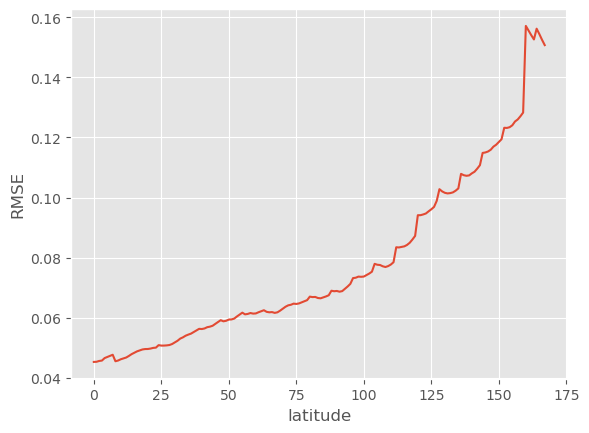

In [ ]:
model = 'AE_without_AP_8_30'
output = output_ae_test_dict[model]
output_shape = output.shape
x_test_shorted = x_test[:,:,:output_shape[2],:]

rmse = torch.sqrt(torch.mean((x_test_shorted - output)**2,dim=(0,1,3))).detach().numpy()
plt.figure()
plt.plot(np.arange(output_shape[2]),rmse)
plt.xlabel("latitude")
plt.ylabel("RMSE")

## Test

### Test all time idx equivalent

In [ ]:
# input_da[0].celerity.data.max()
#  ###* test

# pickle_ae_path = glob.glob(f"{ae_dir_path}/**/*.pickle", recursive=True)

# for pickle_path in pickle_ae_path:
#     arch_shape_struct = '_'.join(pickle_path.split('/')[-4].split('_')[:-3])
    
#     xp = ae_path.split('/')[-5]
#     print(f"\nxp:{xp}  architecture:{arch_shape_struct}")
    
#     with open(pickle_path, 'rb') as file:
#         time_idx_split = pickle.load(file)
#     print(time_idx_split['test'][:2], '...', time_idx_split['test'][-2:])

### Test input_da and dm equivalent

In [ ]:
# print(input_da[0].celerity.data.min())
# print(input_da[0].celerity.data.max())

# print(input_da[1].ecs.data.min())
# print(input_da[1].ecs.data.max())
# print(input_da[0].isel(time =0, lat = 0, lon = 0).celerity.data.min(), input_da[0].isel(time =0, lat = 0, lon = 0).celerity.data.max())
# print(input_da[1].isel(time =10, lat = 100).ecs.data.min(), input_da[1].isel(time =10, lat = 100).ecs.data.max())

NameError: name 'input_da' is not defined

In [ ]:
#input_da[0].sel(time=time_idx_split['test']).isel(time=profile_idx_dict['random_1000'][0, 0], lat = profile_idx_dict['random_1000'][0, 1], lon = profile_idx_dict['random_1000'][0, 2]).celerity.data

array([1537.79444309, 1537.8120375 , 1537.83211305, 1537.85469002,
       1537.87695489, 1537.89577005, 1537.91138545, 1537.92329007,
       1537.93592685, 1537.94937789, 1537.96275188, 1537.97247892,
       1537.97007617, 1537.94456972, 1537.88002621, 1537.75066882,
       1537.5202971 , 1537.15063131, 1536.66860377, 1536.13986133,
       1535.54545555, 1534.86380868, 1534.1175004 , 1533.32985097,
       1532.49103359, 1531.58792732, 1530.64023533, 1529.68278703,
       1528.73412263, 1527.80202467, 1526.90329007, 1526.05412485,
       1525.28419641, 1524.59929911, 1523.99082513, 1523.45079563,
       1522.97638191, 1522.56019129, 1522.18226416, 1521.82125405,
       1521.46342942, 1521.1105232 , 1520.77193478, 1520.45090729,
       1520.13925089, 1519.83010401, 1519.52632069, 1519.23037905,
       1518.94180007, 1518.65627872, 1518.36626339, 1518.06479605,
       1517.74444892, 1517.39415249, 1517.00415879, 1516.57174701,
       1516.08877121, 1515.53815519, 1514.89891842, 1514.14851

In [ ]:
#x_test[ 5, :, 113 , 76]*(x_max - x_min)+ x_min

tensor([1537.7944, 1537.8120, 1537.8322, 1537.8547, 1537.8770, 1537.8958,
        1537.9114, 1537.9233, 1537.9359, 1537.9495, 1537.9628, 1537.9725,
        1537.9701, 1537.9446, 1537.8800, 1537.7507, 1537.5203, 1537.1506,
        1536.6686, 1536.1399, 1535.5455, 1534.8639, 1534.1176, 1533.3298,
        1532.4911, 1531.5879, 1530.6403, 1529.6829, 1528.7341, 1527.8020,
        1526.9033, 1526.0542, 1525.2842, 1524.5994, 1523.9908, 1523.4508,
        1522.9764, 1522.5602, 1522.1823, 1521.8213, 1521.4635, 1521.1106,
        1520.7720, 1520.4509, 1520.1393, 1519.8301, 1519.5264, 1519.2305,
        1518.9418, 1518.6562, 1518.3663, 1518.0648, 1517.7445, 1517.3942,
        1517.0042, 1516.5718, 1516.0887, 1515.5382, 1514.8989, 1514.1486,
        1513.2996, 1512.4030, 1511.5081, 1510.6532, 1509.8706, 1509.1581,
        1508.4673, 1507.7526, 1506.9994, 1506.2029, 1505.3644, 1504.4930,
        1503.5850, 1502.6359, 1501.6638, 1500.6716, 1499.6462, 1498.6036,
        1497.5933, 1496.6766, 1495.856

In [ ]:
#y_test[profile_idx_dict['random_1000'][100, 0], 0, profile_idx_dict['random_1000'][100, 1], profile_idx_dict['random_1000'][100, 2]]*670.25141631

tensor(65.9160)

In [ ]:
#input_da[1].sel(time=time_idx_split['test']).isel(time=profile_idx_dict['random_1000'][100, 0], lat = profile_idx_dict['random_1000'][100, 1], lon = profile_idx_dict['random_1000'][100, 2]).ecs.data

array(65.91599617)

# Get AE RMSE dict

In [ ]:
ecs_from_ae_rmse_dict = {}
celerity_from_ae_rmse_dict = {}
profiles = 'random_1000'

for arch_shape, output_ae_test in output_ae_test_dict.items():
    output_ae_test_shape = output_ae_test.shape
    ecs_list = []
    ecs_truth_list = []

    for i in range(len(profile_idx_dict[profiles])):
        try: ###* manage the fact that output_ae_test shape is variant
            ecs_list.append(get_ecs(coords_da['z'].values[:output_ae_test_shape[2]], output_ae_test[profile_idx_dict[profiles][i, 0], :, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]))
            ###* results of reduce_profiles does not changed if output_ae is normalized or not
            ecs_truth_list.append(y_test[profile_idx_dict[profiles][i, 0], 0, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]*670.25141631)
        
        except:
            continue

    ecs_from_ae_rmse_dict[arch_shape] = np.sqrt(np.mean((ecs_truth_list - np.array(ecs_list))**2))
    celerity_from_ae_rmse_dict[arch_shape]  = torch.sqrt(torch.mean((x_test[:,:,:output_ae_test_shape[2],:] - output_ae_test)**2)).item()

In [ ]:
sorted_celerity_from_ae_rmse_dict = dict(sorted(celerity_from_ae_rmse_dict.items(), key=lambda item: item[1]))
sorted_celerity_from_ae_rmse_dict

{'AE_without_AP_20_60_dense_avgpool_upsample_no_activation': 0.05560332536697388,
 'AE_without_AP_4_60_dense_avgpool_upsample_no_activation': 0.05901859328150749,
 'AE_without_AP_32_120': 0.06832978129386902,
 'AE_without_AP_16_60': 0.07019969075918198,
 'AE_without_AP_8_30': 0.08263549953699112,
 'AE_without_AP_20_60_dense_avgpool_upsample_all_Relu': 0.33300772309303284,
 'AE_without_AP_20_60_dense_avgpool_upsample_final_Relu': 0.3373722434043884,
 'AE_without_AP_no_pool_20': 0.3664037585258484,
 'AE_without_AP_4_60_dense_avgpool_upsample_final_Relu': 0.39561548829078674,
 'AE_without_AP_no_pool_4': 0.41230151057243347,
 'AE_without_AP_4_60_dense_avgpool_upsample_all_Relu': 0.41814813017845154}

In [ ]:
sorted_ecs_from_ae_rmse_dict = dict(sorted(ecs_from_ae_rmse_dict.items(), key=lambda item: item[1]))
sorted_ecs_from_ae_rmse_dict

{'AE_without_AP_no_pool_4': 119.51833659920929,
 'AE_without_AP_20_60_dense_avgpool_upsample_all_Relu': 119.73676322892467,
 'AE_without_AP_20_60_dense_avgpool_upsample_final_Relu': 120.16096173652177,
 'AE_without_AP_no_pool_20': 120.95533190518286,
 'AE_without_AP_32_120': 121.05334742489613,
 'AE_without_AP_4_60_dense_avgpool_upsample_no_activation': 121.35172920796336,
 'AE_without_AP_4_60_dense_avgpool_upsample_all_Relu': 121.38669491866249,
 'AE_without_AP_4_60_dense_avgpool_upsample_final_Relu': 121.44672501517641,
 'AE_without_AP_16_60': 121.61813785646716,
 'AE_without_AP_20_60_dense_avgpool_upsample_no_activation': 122.06993324512248,
 'AE_without_AP_8_30': 122.2713935774227}

In [ ]:
rmse_ae_dict = dict(celerity=sorted_celerity_from_ae_rmse_dict,
                    ecs=sorted_ecs_from_ae_rmse_dict)

# PCA over depth

In [ ]:

input_train_depth_feature = x_train.reshape(-1, input_train_shape[1]).to('cpu')
input_test_depth_feature = x_test.reshape(-1, input_test_shape[1]).to('cpu')

print("train depth shape:", input_train_depth_feature.shape)
print("test depth shape:", input_train_depth_feature.shape)


train depth shape: torch.Size([10690560, 107])
test depth shape: torch.Size([10690560, 107])


### Get RMSE per components

In [ ]:
if not load_data:
    rmse_dict_ss = {}
    rmse_dict_ecs = {}
    n_components_list = [i for i in range(1, 16)] + [30, 50, 100, 107]
    profiles = 'random_1000'
    for n_components in tqdm(n_components_list, unit = "components", desc = "Computing ECS error per PCA components"):
        print(f"PCA over {n_components} components")
        pca = PCA(n_components = n_components, svd_solver = 'auto')
        pca.fit(input_train_depth_feature)
        output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
        #output_test_decoded_pca = output_test_decoded_pca*(x_testx_max - x_min)+ x_min

        ecs_list = []
        ecs_truth_list = [y_test[profile_idx_dict[profiles][i, 0], 0, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]*670.25141631 for i in range(len(profile_idx_dict[profiles]))]
        for i in range(len(profile_idx_dict[profiles])):
            ecs_list.append(get_ecs(coords_da['z'].values, output_test_decoded_pca[profile_idx_dict[profiles][i, 0], :, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]))
        

        rmse_dict_ecs[n_components]=np.sqrt(np.mean((np.array(ecs_truth_list) - np.array(ecs_list))**2))
        rmse_dict_ss[n_components]= torch.sqrt(torch.mean((x_test - output_test_decoded_pca)**2)).item()

    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_ecs.pkl", "wb") as file:
        pickle.dump(rmse_dict_ecs, file)   
    
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_celerity.pkl", "wb") as file:
        pickle.dump(rmse_dict_ss, file)    
        

else:
   
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_ecs.pkl", "rb") as file:
        rmse_dict_ecs_per_components = pickle.load(file)    
    with open("/homes/o23gauvr/Documents/thèse/code/FASCINATION/pickle/pca_rmse_celerity.pkl", "rb") as file:
        rmse_dict_ss_per_componnents = pickle.load(file)    
        
    

In [ ]:
rmse_pca_per_components_dict = dict(celerity=rmse_dict_ss_per_componnents,
                                    ecs=rmse_dict_ecs_per_components)

output_test_decoded_pca_dict = dict()

for n_components in tqdm([4,10,20,107], unit = "components", desc = "Computing ECS error per PCA components"):
        pca = PCA(n_components = n_components, svd_solver = 'auto')
        pca.fit(input_train_depth_feature)
        output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
        output_test_decoded_pca_dict[n_components] = output_test_decoded_pca

Computing ECS error per PCA components: 100%|██████████| 3/3 [05:45<00:00, 115.10s/components]


Text(0.5, 1.0, 'Ratio of the explained variance per number of components used in the PCA')

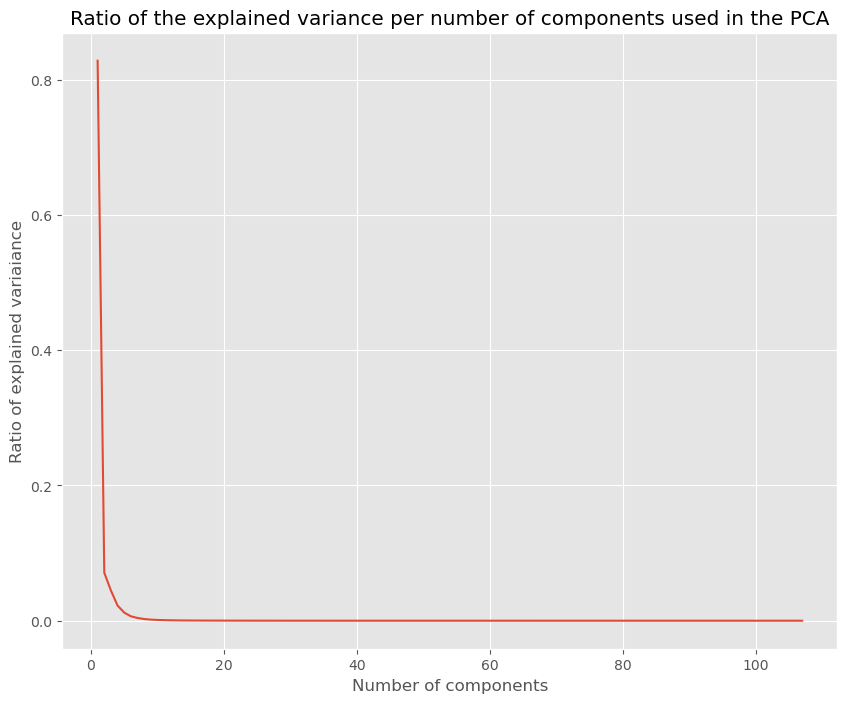

In [ ]:
plt.figure(figsize=(10, 8))
plt.plot(np.arange(1, 108), pca.explained_variance_ratio_)
plt.ylabel("Ratio of explained variaiance")
plt.xlabel("Number of components")
plt.title("Ratio of the explained variance per number of components used in the PCA")

In [ ]:
%%script false --no-raise-error


print("Computing PCA encoding/decoding over test dataset for every svd solver:")
profiles = 'random_1000'
ecs_truth_list = [y_test[profile_idx_dict[profiles][i, 0], 0, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]*670.25141631 for i in range(len(profile_idx_dict[profiles]))]
for solver in ['auto', 'full', 'arpack', 'randomized']:
    ecs_list = []
    if solver == 'arpack':
        n_components = 106
    else:
        n_components = 107
    print("\nSvd solver:", solver)
    print(f"Number of components: {n_components}")
    
    start_time = time.time()
    
    
    pca = PCA(n_components = n_components, svd_solver = solver)
    pca.fit(input_train_depth_feature)
    output_test_decoded_pca = pca.inverse_transform(pca.transform(input_test_depth_feature)).reshape(input_test_shape)
    

    for i in range(len(profile_idx_dict[profiles])):
        ecs_list.append(get_ecs(coords_da['z'].values, output_test_decoded_pca[profile_idx_dict[profiles][i, 0], :, profile_idx_dict[profiles][i, 1], profile_idx_dict[profiles][i, 2]]))
        
        
    end_time = time.time()
    
    print(f"Computing time: {np.round(end_time - start_time, 2)}s \
            \nMax explained variance ratio: {np.round(np.min(pca.explained_variance_ratio_), 4)} for the {np.argmin(pca.explained_variance_ratio_) + 1}th component \
            \nMean precision: {np.round(np.mean(pca.get_precision()), 4)} \
            \nAverage log-likelihood of all samples: {np.round(pca.score(input_test_depth_feature), 4)} \
            \nRMSE over the celerity: {np.round(torch.sqrt(torch.mean((x_test - output_test_decoded_pca)**2)).item(), 4)} \
            \nRMSE over the ECS over 1000 random samples: {np.round(np.sqrt(np.mean((np.array(ecs_truth_list) - np.array(ecs_list))**2)), 4)}")


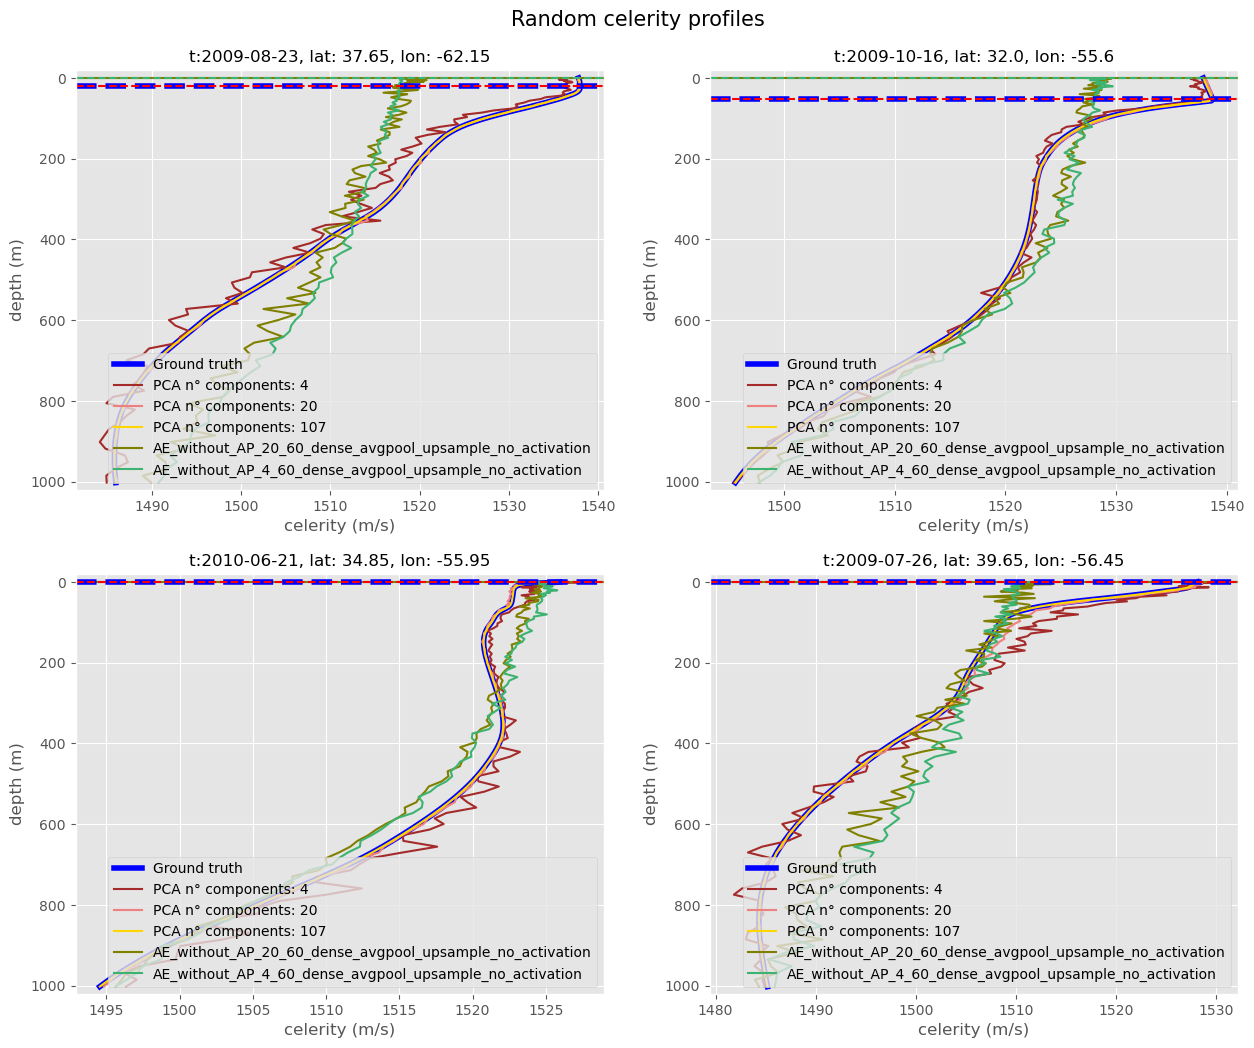

In [ ]:
ae_model_list = list(sorted_celerity_from_ae_rmse_dict.keys())
#ae_model_list = [ae_model_list[0], ae_model_list[-1]]
ae_model_list = ae_model_list[:2]
profiles = 'random_1000'

plot_4_profiles(output_test_decoded_pca_dict,ae_model_list,profiles)

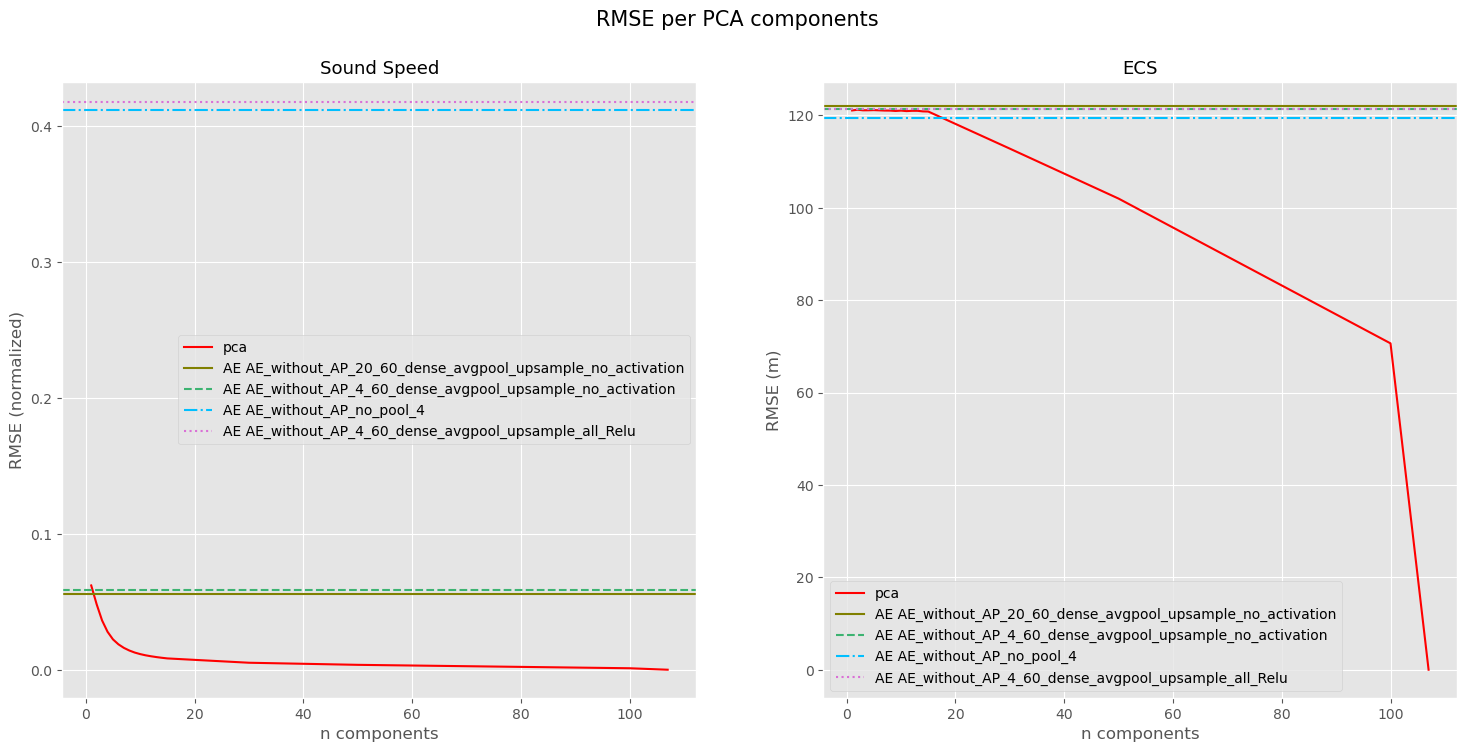

In [ ]:
mode_ae_list = list(sorted_celerity_from_ae_rmse_dict.keys())
mode_ae_list = [mode_ae_list[0], mode_ae_list[1], mode_ae_list[-2], mode_ae_list[-1]]


RMSE_per_PCA_components(rmse_pca_per_components_dict,rmse_ae_dict,mode_ae_list)

# ECS check

In [ ]:

tst_mike_z_w = np.array([0., 100., 200., 300., 400., 500., 600., 
                                700., 800., 900., 1000., 1100., 1300., 
                                1400., 1500., 1600., 1700., 1800., 1900., 
                                2000., 2100., 2200., 2300., 2400., 2500., 
                                2600., 3000.])
tst_mike_sos_w = np.array([1536.8, 1538.5, 1530.2, 1523.4, 1517.7, 
                                    1513.1, 1509.4, 1506.5, 1504.2, 1502.5, 
                                    1501.3, 1500.50, 1500.1, 1500.0, 
                                    1500.1, 1500.4, 1501.0, 1501.7, 1502.5, 
                                    1503.5, 1504.6, 1505.7, 1507.0, 1508.3, 
                                    1509.6, 1511.0, 1512.5])
# NOVEMBER profile
tst_nov_z_w = np.array([0., 4.1, 8.2, 13.0, 18.4, 24.7, 32.0, 
                                40.3, 49.9, 60.9, 73.55, 88.1, 104.8, 
                                124.0, 145.0, 166.1, 187.1, 208.1, 229.1, 
                                250.1, 271.1, 292.1, 329.7, 361.7, 398.6, 
                                535.8, 623.0, 887.4, 887.4, 887.4, 887.4, 
                                887.4, 887.4])
tst_nov_sos_w = np.array([1513.4246, 1513.0774, 1513.157, 
                                1513.2363, 1513.323,  1513.4213, 
                                1513.5321, 1513.6555, 1513.7941, 
                                1513.8442, 1513.646, 1513.7023, 
                                1511.871, 1510.4368, 1509.9404, 
                                1510.0405, 1509.4906, 1509.3845, 
                                1509.4773, 1509.7028, 1509.9937, 
                                1510.3146, 1510.911, 
                                1511.3512, 1511.7878, 1513.807, 
                                1514.7437, 1518.7205, np.nan, np.nan, np.nan, 
                                np.nan, np.nan])

typical_profiles = dict(mike= (tst_mike_z_w, tst_mike_sos_w), 
                        november= (tst_nov_z_w, tst_nov_sos_w))

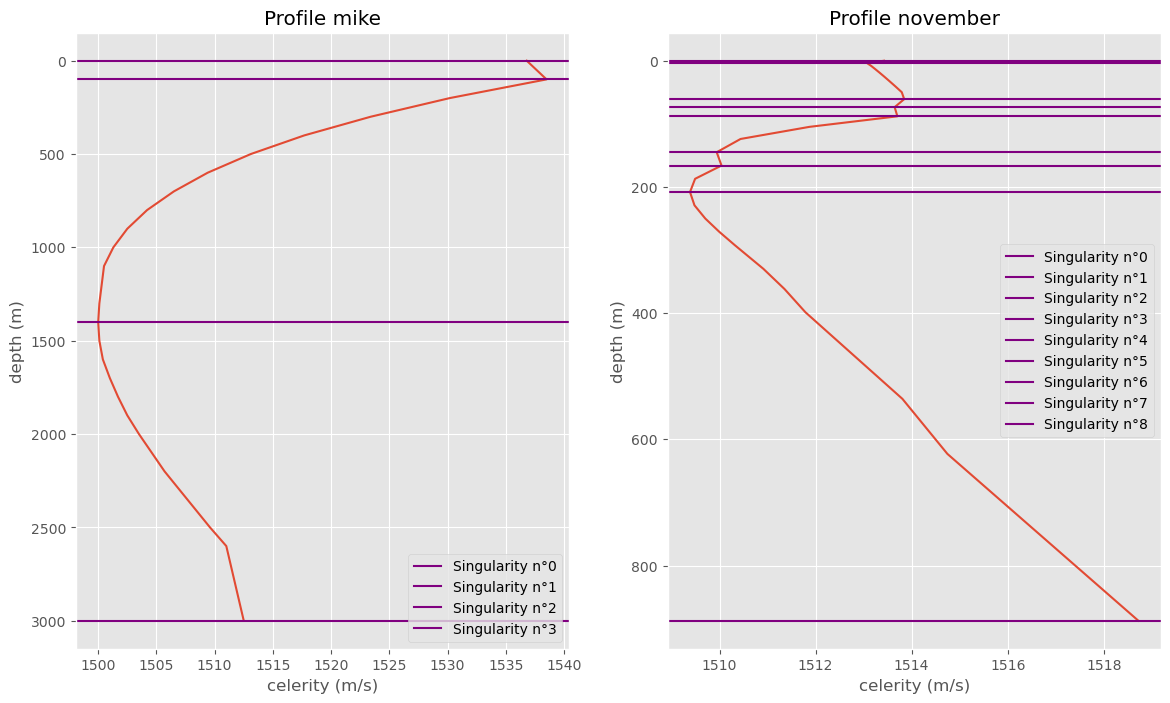

In [ ]:
fig, axs = plt.subplots(1, 2, figsize = (14, 8))
style = ['-', '--', '-.', ':']
for i, items in enumerate(typical_profiles.items()):
    ax = axs[i]
    name, profiles = items 
    z, c = profiles
    
    ax.plot(c, z)
    
    for j, singularity in enumerate(reduce_profile(z, c)[0]):   ##? use get_ecs
        ax.axhline(y=singularity, label=f'Singularity n°{j}', c='purple')
    
    ax.invert_yaxis()
    ax.set_xlabel('celerity (m/s)')
    ax.set_ylabel('depth (m)')
    ax.set_title(f"Profile {name}")
    ax.legend()

# for i, ax in enumerate(axs.flatten()):
#     ax.plot

# normalization

In [12]:
from src.utils import *
import hydra
import src.differentiable_fonc as DF
from sklearn.decomposition import PCA


In [2]:
gpu = None
    
if torch.cuda.is_available() and gpu is not None:
##This may not be necessary outside the notebook
    dev = f"cuda:{gpu}"
else:
    dev = "cpu"

device = torch.device(dev)

In [3]:


cfg_path = "config/xp/autoencoder_V2.yaml"
cfg = OmegaConf.load(cfg_path)
display(Markdown("""```yaml\n\n""" +yaml.dump(OmegaConf.to_container(cfg), default_flow_style=None, indent=2)+"""\n\n```"""))


```yaml

datamodule:
  _target_: src.autoencoder_datamodule.AutoEncoderDatamodule_${dimensions}
  depth_pre_treatment: {method: pca, params: 107}
  dl_kw: {batch_size: '${model_config.batch_size.${dimensions}}', num_workers: 2}
  dtype_str: ${dtype}
  input_da: {_target_: src.utils.load_ssp_da, ssf_da_path: '${paths.sound}'}
  manage_nan: suppress
  n_profiles: null
  norm_stats: {method: mean_std, params: '${normalization.${datamodule.norm_stats.method}}'}
dimensions: 3D
dtype: float32
entrypoints:
- {_target_: pytorch_lightning.seed_everything, seed: 333}
- {_target_: src.train.base_training, dim: '${dimensions}', dm: '${datamodule}', lit_mod: '${model}',
  trainer: '${trainer}'}
hydra:
  job:
    env_set: {CUDA_VISIBLE_DEVICES: 0}
  run: {dir: '${trainer.logger.save_dir}/${trainer.logger.name}/${trainer.logger.version}'}
model:
  _target_: src.autoencoder_V2.AutoEncoder
  depth_array: {_target_: src.utils.get_depth_array, ssf_da_path: '${paths.sound}'}
  dim: ${dimensions}
  loss_weight: {ecs_weight: 0, fft_weight: 0, gradient_weight: 0, inflection_pos_weight: 0,
    inflection_value_weight: 0, max_position_weight: 0, max_value_weight: 0, prediction_weight: 1,
    weighted_weight: 0}
  model_hparams: ${model_config.model_hparams.${model.model_name}}
  model_name: ${model_architecture}_${dimensions}
  opt_fn: {T_max: '${trainer.max_epochs}', _partial_: true, _target_: src.ecs_classification.ECS_classification.cosanneal_lr_adamw,
    lr: 0.001, weight_decay: 0.001}
model_architecture: AE_CNN
model_config:
  accumulate_grad_batches: {1D: 1, 2D: 1, 3D: 1}
  batch_size: {1D: 512, 2D: 32, 3D: 4}
  model_hparams:
    AE_CNN_1D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Elu
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 9
      linear_layer: false
      n_conv_per_layer: 1
      padding: linear
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_2D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Elu
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
    AE_CNN_3D:
      act_fn_str: Elu
      channels_list: [1, 1]
      dropout_proba: 0
      final_act_fn_str: Elu
      final_upsample_str: upsample_pooling
      interp_size: 0
      latent_size: 50
      linear_layer: false
      n_conv_per_layer: 1
      padding: reflect
      pooling: None
      pooling_dim: spatial
      upsample_mode: trilinear
  save_dir: {AE_CNN: 'channels_${model.model_hparams.channels_list}/upsample_mode_${model.model_hparams.upsample_mode}/linear_later_${model.model_hparams.linear_layer}_lattent_size_${model.model_hparams.latent_size}/${model.model_hparams.n_conv_per_layer}_conv_per_layer/padding_${model.model_hparams.padding}/interp_size_${model.model_hparams.interp_size}/pooling_${model.model_hparams.pooling}_on_dim_${model.model_hparams.pooling_dim}/final_upsample_${model.model_hparams.final_upsample_str}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}',
    AE_CNN_pool_1D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}',
    AE_CNN_pool_2D: 'latent_dim_${model.model_hparams.latent_dim}_pooling_${model.model_hparams.num_layers}_${model.model_hparams.pooling_str}_dropout_${model.model_hparams.dropout_proba}_patience_${patience}/act_fn_${model.model_hparams.act_fn_str}_final_act_fn_${model.model_hparams.final_act_fn_str}_normalization_${datamodule.norm_stats.method}'}
normalization:
  mean_std: {mean: null, std: null}
  mean_std_along_depth: {mean: null, std: null}
  min_max: {x_max: null, x_min: null}
paths: {sound: /DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc}
patience: 5
root_save_dir: "/homes/o23gauvr/Documents/th\xE8se/code/FASCINATION/outputs"
save_dir_name: test
trainer:
  _target_: pytorch_lightning.Trainer
  accelerator: gpu
  accumulate_grad_batches: ${model_config.accumulate_grad_batches.${dimensions}}
  callbacks:
  - {_target_: pytorch_lightning.callbacks.LearningRateMonitor}
  - {_target_: pytorch_lightning.callbacks.ModelCheckpoint, filename: '{val_loss:.2f}-{epoch:02d}',
    mode: min, monitor: val_loss, save_top_k: 1}
  - {_target_: pytorch_lightning.callbacks.EarlyStopping, min_delta: 1.0e-06, monitor: val_loss,
    patience: '${trainer.max_epochs}', verbose: true}
  check_val_every_n_epoch: 1
  devices: 1
  inference_mode: false
  logger: {_target_: pytorch_lightning.loggers.tensorboard.TensorBoardLogger, log_graph: true,
    name: '${save_dir_name}', save_dir: '${root_save_dir}/AE/${model.model_name}',
    version: 'pred_${model.loss_weight.prediction_weight}_grad_${model.loss_weight.gradient_weight}_max_pos_${model.loss_weight.max_position_weight}_max_value_${model.loss_weight.max_value_weight}_fft_${model.loss_weight.fft_weight}_weighted_${model.loss_weight.weighted_weight}_inflection_pos_${model.loss_weight.inflection_pos_weight}_inflection_value_${model.loss_weight.inflection_value_weight}/depth_pre_treatment_${datamodule.depth_pre_treatment.method}_n_components_${datamodule.depth_pre_treatment.params}/${model_config.save_dir.${model_architecture}}/lr_${model.opt_fn.lr}/normalization_${datamodule.norm_stats.method}/manage_nan_${datamodule.manage_nan}/n_profiles_${datamodule.n_profiles}/${now:%Y-%m-%d_%H-%M}'}
  max_epochs: 10
  min_epochs: 0


```

In [4]:
dm_dict = cfg.datamodule
dm = hydra.utils.call(dm_dict) #hydra.utils.call(dm_dict)
train_ssp_tens, test_ssp_tens, dm, coords = loading_datamodule(dm)

In [5]:
train_ssp_tens

tensor([[[[166.8261, 166.8079, 166.7701,  ..., 166.8768, 166.8772, 166.8779],
          [166.8227, 166.7993, 166.7545,  ..., 166.8801, 166.8779, 166.8774],
          [166.8131, 166.7852, 166.7353,  ..., 166.8930, 166.8881, 166.8853],
          ...,
          [164.7354, 165.0620, 165.2567,  ..., 166.2510, 166.2632, 166.2773],
          [165.0560, 165.2491, 165.2831,  ..., 166.2218, 166.2456, 166.2602],
          [165.2219, 165.3313, 165.3205,  ..., 166.1607, 166.2104, 166.2418]],

         [[166.8282, 166.8100, 166.7722,  ..., 166.8248, 166.8256, 166.8267],
          [166.8248, 166.8014, 166.7565,  ..., 166.8279, 166.8260, 166.8260],
          [166.8152, 166.7872, 166.7374,  ..., 166.8412, 166.8364, 166.8340],
          ...,
          [164.7189, 165.0491, 165.2431,  ..., 166.2401, 166.2525, 166.2669],
          [165.0431, 165.2359, 165.2690,  ..., 166.2102, 166.2345, 166.2495],
          [165.2091, 165.3181, 165.3068,  ..., 166.1480, 166.1985, 166.2306]],

         [[166.8305, 166.8123,

In [6]:
sound_speed_path =  "/DATASET/eNATL/eNATL60_BLB002_sound_speed_regrid_0_1000m.nc"
ssp_da = load_ssp_da(sound_speed_path)

In [9]:
ssp_da

<xarray.DataArray 'celerity' (time: 365, z: 107, lat: 174, lon: 240)>
array([[[[1532.705152, ..., 1531.562345],
         ...,
         [1515.375436, ..., 1532.201748]],

        ...,

        [[1494.096106, ..., 1494.359212],
         ...,
         [1484.081209, ..., 1485.735138]]],


       ...,


       [[[1535.743611, ..., 1534.325997],
         ...,
         [1503.952488, ..., 1518.802041]],

        ...,

        [[1494.44955 , ..., 1494.455818],
         ...,
         [1484.401103, ..., 1485.070959]]]])
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.6 32.65 32.7 32.75 32.8 ... 41.2 41.25 41.3 41.35
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [8]:
ssp_da = ssp_da.dropna(dim='lat')
ssp_da

<xarray.DataArray 'celerity' (time: 365, z: 107, lat: 174, lon: 240)>
array([[[[1532.705152, ..., 1531.562345],
         ...,
         [1515.375436, ..., 1532.201748]],

        ...,

        [[1494.096106, ..., 1494.359212],
         ...,
         [1484.081209, ..., 1485.735138]]],


       ...,


       [[[1535.743611, ..., 1534.325997],
         ...,
         [1503.952488, ..., 1518.802041]],

        ...,

        [[1494.44955 , ..., 1494.455818],
         ...,
         [1484.401103, ..., 1485.070959]]]])
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.6 32.65 32.7 32.75 32.8 ... 41.2 41.25 41.3 41.35
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-07-01T12:00:00 ... 2010-06-30T12:00:00

In [ ]:
output_train_da = ssp_da.isel(time=dm.train_time_idx)

In [10]:
train_data_array = output_train_da.data

In [13]:
train_shape = train_data_array.shape
train_shape

(255, 107, 174, 240)

In [15]:
n_components = 107
pca = PCA(n_components = n_components, svd_solver = 'auto')


In [17]:
reduced_train_data = pca.fit_transform(train_data_array.transpose(0,2,3,1).reshape(-1,train_shape[1]))
reduced_train_data.shape

(10648800, 107)

In [18]:
reduced_min = reduced_train_data.min()
reduced_max = reduced_train_data.max()
reduced_mean = reduced_train_data.mean()
reduced_mean_along_depth = reduced_train_data.mean(axis=1)
reduced_std = reduced_train_data.std()

min max normalization

In [20]:
min_max_data = (reduced_train_data - reduced_min)/(reduced_max - reduced_min) 

print(min_max_data.min(),min_max_data.max(),min_max_data.mean(),min_max_data.std())

0.0 1.0 0.3000578194387578 0.020888310294563013


In [34]:
output_train_da.data = pca.inverse_transform(min_max_data).reshape(train_shape[0],train_shape[2],train_shape[3],train_shape[1]).transpose(0,3,1,2)


<xarray.DataArray 'celerity' (time: 255, z: 107, lat: 174, lon: 240)>
array([[[[1527.36781518, 1527.36743567, 1527.36664577, ...,
          1527.36887413, 1527.36888315, 1527.3688965 ],
         [1527.36774456, 1527.36725629, 1527.36631907, ...,
          1527.36894254, 1527.36889794, 1527.3688873 ],
         [1527.36754422, 1527.36696011, 1527.36591857, ...,
          1527.36921288, 1527.36911064, 1527.36905265],
         ...,
         [1527.32414316, 1527.33096682, 1527.33503356, ...,
          1527.35580309, 1527.35605744, 1527.35635254],
         [1527.33083973, 1527.33487362, 1527.33558509, ...,
          1527.35519259, 1527.35568992, 1527.35599467],
         [1527.33430594, 1527.33659123, 1527.33636594, ...,
          1527.35391578, 1527.35495425, 1527.35561042]],

        [[1527.55001878, 1527.54963928, 1527.54884937, ...,
          1527.54994799, 1527.54996547, 1527.54998827],
         [1527.54994817, 1527.54945991, 1527.54852266, ...,
          1527.55001234, 1527.54997371, 1527.54997332],
         [1527.54974783, 1527.54916372, 1527.54812211, ...,
          1527.55029052, 1527.55019139, 1527.55014134],
...
         [1495.15885799, 1495.15889094, 1495.15878797, ...,
          1495.16011115, 1495.16012816, 1495.16014127],
         [1495.15881013, 1495.15881972, 1495.15873407, ...,
          1495.15998802, 1495.16000111, 1495.16000942],
         [1495.15866174, 1495.1587155 , 1495.15869117, ...,
          1495.15996988, 1495.15997468, 1495.15995869]],

        [[1494.09924939, 1494.09903146, 1494.09869583, ...,
          1494.09437166, 1494.09431561, 1494.09435061],
         [1494.09890539, 1494.09868542, 1494.09838695, ...,
          1494.09400967, 1494.0940704 , 1494.09417898],
         [1494.09851469, 1494.09831642, 1494.098064  , ...,
          1494.0938645 , 1494.09397583, 1494.09413855],
         ...,
         [1494.07540621, 1494.07543241, 1494.07531621, ...,
          1494.07656933, 1494.07658628, 1494.07659865],
         [1494.07533998, 1494.07534977, 1494.07525803, ...,
          1494.07645148, 1494.07646038, 1494.07646893],
         [1494.07523117, 1494.07526211, 1494.07521346, ...,
          1494.0764308 , 1494.07643854, 1494.07642232]]]])
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.6 32.65 32.7 32.75 32.8 ... 41.2 41.25 41.3 41.35
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-08-22T12:00:00 ... 2010-04-06T12:00:00

In [37]:
x = torch.tensor(output_train_da.data)
dif_pca_4D = DF.Differentiable4dPCA(pca)
x = dif_pca_4D.transform(x)

print(x.min(),x.max(),x.mean(),x.std())

tensor(-4.0026e-05, dtype=torch.float64) tensor(1.0000, dtype=torch.float64) tensor(0.3001, dtype=torch.float64) tensor(0.0209, dtype=torch.float64)


: 

mean std

In [21]:
mean_std_data = (reduced_train_data - reduced_mean)/(reduced_std) 

print(mean_std_data.min(),mean_std_data.max(),mean_std_data.mean(),mean_std_data.std())

-14.364867967173682 33.50879849498497 1.5271775453326271e-18 1.000000000000005


mean along depth std

In [31]:
reduced_mean_along_depth =  (reduced_train_data - reduced_mean_along_depth.reshape(-1,1))/(reduced_std) 
print(reduced_mean_along_depth.min(),reduced_mean_along_depth.max(),reduced_mean_along_depth.mean(),reduced_mean_along_depth.std())

-14.369331593404281 32.996504758425274 -2.654039455979232e-18 0.9953161335010359


<xarray.DataArray 'celerity' (time: 255, z: 107, lat: 174, lon: 240)>
array([[[[1527.36781518, 1527.36743567, 1527.36664577, ...,
          1527.36887413, 1527.36888315, 1527.3688965 ],
         [1527.36774456, 1527.36725629, 1527.36631907, ...,
          1527.36894254, 1527.36889794, 1527.3688873 ],
         [1527.36754422, 1527.36696011, 1527.36591857, ...,
          1527.36921288, 1527.36911064, 1527.36905265],
         ...,
         [1527.32414316, 1527.33096682, 1527.33503356, ...,
          1527.35580309, 1527.35605744, 1527.35635254],
         [1527.33083973, 1527.33487362, 1527.33558509, ...,
          1527.35519259, 1527.35568992, 1527.35599467],
         [1527.33430594, 1527.33659123, 1527.33636594, ...,
          1527.35391578, 1527.35495425, 1527.35561042]],

        [[1527.55001878, 1527.54963928, 1527.54884937, ...,
          1527.54994799, 1527.54996547, 1527.54998827],
         [1527.54994817, 1527.54945991, 1527.54852266, ...,
          1527.55001234, 1527.54997371, 1527.54997332],
         [1527.54974783, 1527.54916372, 1527.54812211, ...,
          1527.55029052, 1527.55019139, 1527.55014134],
...
         [1495.15885799, 1495.15889094, 1495.15878797, ...,
          1495.16011115, 1495.16012816, 1495.16014127],
         [1495.15881013, 1495.15881972, 1495.15873407, ...,
          1495.15998802, 1495.16000111, 1495.16000942],
         [1495.15866174, 1495.1587155 , 1495.15869117, ...,
          1495.15996988, 1495.15997468, 1495.15995869]],

        [[1494.09924939, 1494.09903146, 1494.09869583, ...,
          1494.09437166, 1494.09431561, 1494.09435061],
         [1494.09890539, 1494.09868542, 1494.09838695, ...,
          1494.09400967, 1494.0940704 , 1494.09417898],
         [1494.09851469, 1494.09831642, 1494.098064  , ...,
          1494.0938645 , 1494.09397583, 1494.09413855],
         ...,
         [1494.07540621, 1494.07543241, 1494.07531621, ...,
          1494.07656933, 1494.07658628, 1494.07659865],
         [1494.07533998, 1494.07534977, 1494.07525803, ...,
          1494.07645148, 1494.07646038, 1494.07646893],
         [1494.07523117, 1494.07526211, 1494.07521346, ...,
          1494.0764308 , 1494.07643854, 1494.07642232]]]])
Coordinates:
  * lon      (lon) float64 -65.95 -65.9 -65.85 -65.8 ... -54.1 -54.05 -54.0
  * lat      (lat) float64 32.6 32.65 32.7 32.75 32.8 ... 41.2 41.25 41.3 41.35
  * z        (z) float64 0.4805 1.559 2.794 4.187 ... 968.4 985.3 1.002e+03
  * time     (time) datetime64[ns] 2009-08-22T12:00:00 ... 2010-04-06T12:00:00